# Thesis work--2
# A new method for multivariate regression problem for improving fitness in Genetic Programming

### Importing the libraries

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randrange, uniform
from sklearn.utils import check_random_state
from sklearn.metrics import mean_squared_error

### Global variables and functions for tuning

In [2]:
FEATURES = 2
NUMBER_OF_GENERATION = 20
ROWS = 300
NUMBER_OF_REGIONS = 3
formula = lambda X: X[:, 0]**2 - X[:, 1]**2 + X[:, 1] - 1

### Generating Training Samples

In [3]:
rng = check_random_state(0)
X = rng.uniform(-1, 1, ROWS).reshape(ROWS//FEATURES, FEATURES)
Y = formula(X)

### Splitting the dataset into the Training set and Test set

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

### Applying PCA

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 1)
#print(X_train)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
#print(X_train_pca)
#print(X_test_pca)
# print(np.shape(X_train),np.shape(X_test))
#print(explained_variance)

### Calculating DV

In [6]:
# sort X_train_pca and y_train by index
sorted_indexes = np.argsort(X_train_pca,axis=0)
sorted_x_train_pca = X_train_pca[sorted_indexes]
sorted_y_train = y_train[sorted_indexes]

# Finding Change of Slope
slope1 = []
slope2 = []
for itr in range(1,len(sorted_x_train_pca)):
    slope1.append((sorted_y_train[itr]-sorted_y_train[itr-1])/(sorted_x_train_pca[itr]-sorted_x_train_pca[itr-1]))
for itr in range(1,len(slope1)):
    slope2.append((slope1[itr]-slope1[itr-1])/(sorted_x_train_pca[itr]-sorted_x_train_pca[itr-1]))

# normalize slope2 
normalized_slope2 = (slope2-min(slope2))/(max(slope2)-min(slope2))

# Calculating Quantiles
normalized_slope2 = np.reshape(normalized_slope2,len(normalized_slope2))
quantile_ranges = pd.qcut(normalized_slope2,NUMBER_OF_REGIONS,labels=False,retbins=True)
quantile_ranges = quantile_ranges[1]

# Adding the difficult Vectors
difficult_points = {}
for q_ind in range(NUMBER_OF_REGIONS):
    low = quantile_ranges[q_ind]
    high = quantile_ranges[q_ind+1]
    difficult_points[q_ind] = []
    for n_ind in range(0,len(normalized_slope2)):
        if normalized_slope2[n_ind] >= low and normalized_slope2[n_ind] <= high:
            difficult_points[q_ind].append(n_ind)
print(difficult_points)

{0: [2, 3, 7, 10, 12, 14, 19, 22, 24, 25, 29, 31, 33, 35, 37, 41, 44, 49, 51, 53, 54, 56, 62, 64, 67, 72, 74, 78, 79, 82, 84, 86, 90, 94, 97, 99, 101, 103, 110, 113], 1: [0, 1, 5, 9, 11, 17, 18, 27, 36, 40, 46, 47, 48, 58, 59, 60, 65, 66, 69, 70, 75, 76, 79, 81, 87, 88, 89, 91, 92, 95, 98, 105, 106, 107, 108, 111, 114, 115, 116, 117], 2: [4, 6, 8, 11, 13, 15, 16, 20, 21, 23, 26, 28, 30, 32, 34, 38, 39, 42, 43, 45, 50, 52, 55, 57, 61, 63, 68, 71, 73, 77, 80, 83, 85, 93, 96, 100, 102, 104, 109, 112]}


### Training of converted PCA

In [7]:
from gplearn.genetic import SymbolicRegressor
est_gp = SymbolicRegressor(population_size=200,
                           generations=NUMBER_OF_GENERATION, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)


### Getting the different regions of difficulty level

In [8]:
# Hard to evolve points
hard_to_evolve_x = X_train_pca[difficult_points[0]]
hard_to_evolve_y = y_train[difficult_points[0]]

# Medium to evolve points
medium_to_evolve_x = X_train_pca[difficult_points[1]]
medium_to_evolve_y = y_train[difficult_points[1]]

# Easy to evolve points
easy_to_evolve_x = X_train_pca[difficult_points[2]]
easy_to_evolve_y = y_train[difficult_points[2]]


### Feed the system hard to evolve points first

In [9]:
est_gp.fit(hard_to_evolve_x,hard_to_evolve_y)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    46.36 103.95173308566565       15 0.5226602104681045 0.18657394344567546      3.96s
   1    11.86 23.322916748615256       33 0.3884718195129449 0.7602442076253353      4.67s
   2    11.55 5.540024311412967       35 0.39116604487612255 0.7285268396738209      4.60s
   3     9.02 1.7667541914578937       11 0.37055460998054696 0.7542954557966416      4.57s
   4     7.01 0.8683875072631347        9 0.3579271037837494 0.753341459143939      4.33s
   5     7.51 0.8936308508199103        9 0.3690778501839116 0.6529847415424794      4.80s
   6     7.03 0.8814993504082793        7 0.369011178876816 0.6078763650522377      4.79s
   7     5.42 0.7360323971326159        5 0.3550027430328087 0.8006980076021338      4.72s
   8     5.47 0.75857284449

### Feed the system Medium to evolve points keeping the current modal state appending generation by current generation

In [10]:
est_gp.set_params(generations=NUMBER_OF_GENERATION*2, warm_start=True)
est_gp.fit(medium_to_evolve_x,medium_to_evolve_y)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  20      5.4 0.8903543725132039        5 0.3393817360350701 0.7455350791063368      0.24s
  21     5.08 0.7943857101105892        5 0.3416565270180202 0.7250619602597863      0.47s
  22     5.54 0.6894790128054473        5 0.32458809052611953 0.8786778886868923      0.68s
  23     5.57 0.8629974275560174        5 0.3406840738790801 0.6312661117174043      0.83s
  24     5.91 1.000437640319763        5 0.33425546474095513 0.7916715207533717      0.93s
  25     5.46 0.6374379955687229        5 0.3283484783056425 0.8448343986711856      1.01s
  26     5.14 0.7438375907032123        5 0.3356697665269631 0.7789428046793003      1.05s
  27     5.05 0.6642443282170993        5 0.3188566175517007 0.827713218663819      1.05s
  28     5.34 1.39118788767

### Same process but for easy to evolve points and this is our result

In [85]:
est_gp.set_params(generations=NUMBER_OF_GENERATION*3, warm_start=True)
est_gp.fit(easy_to_evolve_x,easy_to_evolve_y)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  40     5.05 0.7225369142325638        5 0.41481548031694193 0.9397840236417476      0.18s
  41     4.86 0.798482772282206        5 0.4120304407060219 0.9648493801400273      0.29s
  42     5.29 1.4473423551602473        5 0.417675859943919 0.9140406069989542      0.42s
  43     4.85 0.8995415782111235        5 0.41958015843496965 0.8969019205794977      0.48s
  44     5.14 0.9849580389314643        5 0.4260040859823168 0.8390865726533734      0.52s
  45     3.84 0.8126980226047249        5 0.39874060087898244 1.0844579385833826      0.55s
  46     4.47 0.7722303318209905        5 0.40226990838292437 1.0526941710479052      0.58s
  47     4.32 0.7457366675863559        5 0.40233619357999334 1.0520976042742842      0.58s
  48     4.27 0.81291747

### Training of data without PCA without DV

In [11]:
# Generating random data
rng = check_random_state(0)
X = rng.uniform(-1, 1, ROWS).reshape(ROWS//FEATURES, FEATURES)
Y = formula(X)
# Dividing it into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
# Training the system
est_gp = SymbolicRegressor(population_size=5000,
                           generations=NUMBER_OF_GENERATION, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train,y_train)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13 14526523.852232037        7 0.34345228187672205 0.39183358697468723      1.33m
   1     9.69 2.2231893389065696        5 0.33069429035251297 0.5045459649453637      1.94m
   2     7.56 7.766714728861279       11 0.2616019900542889 0.23186375873633394      1.94m
   3     5.16 1.9396369188353464       11 0.24135048493135755 0.23860510524886103      1.76m
   4     4.22 1.1487231745028432       11 0.2324422917308899 0.31877884405306967      1.59m
   5     5.72 2.1585597689821436       11 0.04361256297008964 0.04361256297008964      1.54m
   6     7.41 1.3965752246192595       11 0.02358750255327835 0.023587502553278333      1.52m
   7     8.09 2.4486306816297625       11 0.023587502553278343 0.02358750255327836      1.55m
   8     9.41

### Calculate fitness 

In [24]:
x0 = X_test[:,0]
x1 = X_test[:,1]
predicted_formula_result_y = ((x0*x0)-(((x1/x1)-x1)+(x1*x1)))
fitness = mean_squared_error(y_test, predicted_formula_result_y)
print('Fitness of Training of data without PCA without DV: '+str(fitness))

Fitness of Training of data without PCA without DV: 3.4923529658221876e-33


### Visualize results without converting data to single dimension

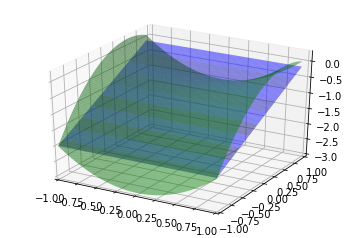

In [101]:
# Generate Data
new_rows = 200
rng = check_random_state(0)
x0 = np.arange(-1,1,.01)
x1 = np.arange(-1,1,0.1)
x0,x1 = np.meshgrid(x0,x1)
y_truth = x0**2 - x1**2 + x1 - 1
fig = plt.figure()
ax=fig.gca(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
surf = ax.plot_surface(x0, x1, y_truth, rstride=1, cstride=1,
                       color='green', alpha=0.5)
y_pred_truth = (x1 - 0.990)
new_surf = ax.plot_surface(x0, x1, y_pred_truth, rstride=1, cstride=1,
                       color='blue', alpha=0.5)
plt.show()

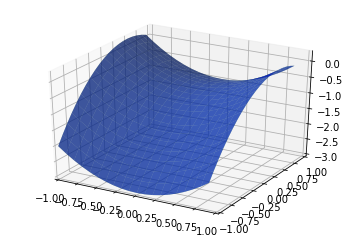

In [113]:
x0 = np.arange(-1, 1, 1/10.)
x1 = np.arange(-1, 1, 1/10.)
x0, x1 = np.meshgrid(x0, x1)
y_truth = x0**2 - x1**2 + x1 - 1

ax = plt.figure().gca(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
surf = ax.plot_surface(x0, x1, y_truth, rstride=1, cstride=1,
                       color='green', alpha=0.5)
y_pred_truth = ((x0*x0)-(((x1/x1)-x1)+(x1*x1)))
new_surf = ax.plot_surface(x0, x1, y_pred_truth, rstride=1, cstride=1,
                       color='blue', alpha=0.5)
plt.show()

In [89]:
# This result produce doesn't look correct even with Standard GP when the population size = 200 
# and the generation size = 60
# but when the population size = 5000 and the generation size = 20 it produces almost perfect results

### Training of data with PCA without DV

In [27]:
# Generating random data
rng = check_random_state(0)
X = rng.uniform(-1, 1, ROWS).reshape(ROWS//FEATURES, FEATURES)
Y = formula(X)

# Dividing it into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

# Convert it to PCA
pca = PCA(n_components = 1)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Training the system
est_gp = SymbolicRegressor(population_size=5000,
                           generations=NUMBER_OF_GENERATION, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train_pca,y_train)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    48.81 7000.897774177602       31 0.3744374991765763 0.4915602789451854      1.74m
   1    11.64 2.47407693468504       31 0.3666405687628576 0.42881852848758334      2.24m
   2      8.3 1.6710659916832853       35 0.3393586343522792 0.5878836105880452      2.24m
   3     5.93 1.2747378235278106       11 0.364712091468606 0.5781278267093605      2.04m
   4     4.84 1.0638379735301824        7 0.35922911244779754 0.6395199068674192      1.85m
   5      4.6 0.9112824204853461        7 0.3520859578958873 0.7038082978346111      1.69m
   6     4.16 1.066459449189631        7 0.3651172546892942 0.586526626693949      1.60m
   7     3.72 1.0094246331235146        7 0.36836594372946213 0.5572884253324378      1.44m
   8     3.56 3.12072811287849

In [28]:
# Multiple runs still produces this result

### Calculate Fitness

In [26]:
x0 = X_test[:,0]
x1 = X_test[:,1]
predicted_formula_result_y = (X0-1)
fitness = mean_squared_error(y_test, predicted_formula_result_y)
print('Training of data with PCA without DV: '+str(fitness))

Training of data with PCA without DV: 1.1264060303374657


### Training of data with PCA with DV

In [62]:
def train_pca_dv(seed_value):
    # Generating random data
    rng = check_random_state(seed_value)
    X = rng.uniform(-1, 1, ROWS).reshape(ROWS//FEATURES, FEATURES)
    Y = formula(X)

    # Dividing it into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
    list_of_x_test.append(X_test)
    list_of_y_test.append(y_test)
    # Convert it to PCA
    pca = PCA(n_components = 1)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Applying DV
    # sort X_train_pca and y_train by index
    sorted_indexes = np.argsort(X_train_pca,axis=0)
    sorted_x_train_pca = X_train_pca[sorted_indexes]
    sorted_y_train = y_train[sorted_indexes]

    # Finding Change of Slope
    slope1 = []
    slope2 = []
    for itr in range(1,len(sorted_x_train_pca)):
        slope1.append((sorted_y_train[itr]-sorted_y_train[itr-1])/(sorted_x_train_pca[itr]-sorted_x_train_pca[itr-1]))
    for itr in range(1,len(slope1)):
        slope2.append((slope1[itr]-slope1[itr-1])/(sorted_x_train_pca[itr]-sorted_x_train_pca[itr-1]))

    # normalize slope2 
    normalized_slope2 = (slope2-min(slope2))/(max(slope2)-min(slope2))

    # Calculating Quantiles
    normalized_slope2 = np.reshape(normalized_slope2,len(normalized_slope2))
    quantile_ranges = pd.qcut(normalized_slope2,NUMBER_OF_REGIONS,labels=False,retbins=True)
    quantile_ranges = quantile_ranges[1]

    # Adding the difficult Vectors
    difficult_points = {}
    for q_ind in range(NUMBER_OF_REGIONS):
        low = quantile_ranges[q_ind]
        high = quantile_ranges[q_ind+1]
        difficult_points[q_ind] = []
        for n_ind in range(0,len(normalized_slope2)):
            if normalized_slope2[n_ind] >= low and normalized_slope2[n_ind] <= high:
                difficult_points[q_ind].append(n_ind)
    # Hard to evolve points
    hard_to_evolve_x = X_train_pca[difficult_points[0]]
    hard_to_evolve_y = y_train[difficult_points[0]]

    # Medium to evolve points
    medium_to_evolve_x = X_train_pca[difficult_points[1]]
    medium_to_evolve_y = y_train[difficult_points[1]]

    # Easy to evolve points
    easy_to_evolve_x = X_train_pca[difficult_points[2]]
    easy_to_evolve_y = y_train[difficult_points[2]]

    # Training the system
    est_gp = SymbolicRegressor(population_size=5000,
                               generations=NUMBER_OF_GENERATION, stopping_criteria=0.01,
                               p_crossover=0.7, p_subtree_mutation=0.1,
                               p_hoist_mutation=0.05, p_point_mutation=0.1,
                               max_samples=0.9, verbose=1,
                               parsimony_coefficient=0.01, random_state=0)
    est_gp.fit(hard_to_evolve_x,hard_to_evolve_y)
#     print(est_gp._program)
    est_gp.set_params(generations=NUMBER_OF_GENERATION*2, warm_start=True)
    est_gp.fit(medium_to_evolve_x,medium_to_evolve_y)
#     print(est_gp._program)
    est_gp.set_params(generations=NUMBER_OF_GENERATION*3, warm_start=True)
    est_gp.fit(easy_to_evolve_x,easy_to_evolve_y)
    print(est_gp._program)
    list_of_est_program.append(str(est_gp._program))

In [63]:
list_of_est_program = []
list_of_x_test = []
list_of_y_test = []
for itr in range(0,20):
    print('Run :',itr+1)
    train_pca_dv(itr) 

Run : 1
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    48.81 2099.013917239532       31 0.35009689848508824 0.7729661837118711      1.69m
   1    12.03 3.5871786512988963       31 0.3680032824922248 0.8138277771174178      2.46m
   2     8.81 1.266108706695252        5 0.35136627160486245 0.9289380526213132      2.48m
   3     6.71 1.1400553306588357        5 0.33290551222112164 1.0325875606337314      2.33m
   4     5.74 1.1051595402167962        5 0.31781911726299733 1.1646633735629643      2.10m
   5     5.44 1.0009514279091665        5 0.3370764860124427 0.9913470548179554      1.89m
   6     5.18 1.4077683933681473        5 0.3175376635910651 1.1497736540641839      1.71m
   7     5.27 0.9976438885464939        5 0.3350455186278304 1.0758248294146013      1.54m
   8     5.25 3.1

  19     1.63 0.8448076323553722        1 0.33655212371211324 1.2769686485572391      0.00s
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  20     1.62 0.9214425017067862        1 0.38323123537412396 1.364132316542027      2.07s
  21     1.57 1.061587177972685        1 0.3731294425860445 1.4787849883826278      3.85s
  22     1.52 0.7874827221127289        1 0.37900668959930583 1.4268128869039218      5.08s
  23      1.6 0.9770295787102663        1 0.3754217168725877 1.4344179830558539      6.02s
  24     1.53 0.8947043188211689        1 0.37384139357744667 1.448640892712123      6.73s
  25     1.59 1.617388955657591        1 0.36608332594750415 1.5184635013816052      7.49s
  26     1.64 1.498344301248685        1 0.36299829097511105 1.5462288161331434      8.41s
  27     1.68 3211.7395354

  39     3.37 0.7790545995026943        3 0.2709420625053214 0.9331925113492738      0.00s
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  40     3.35  4.4900266172014        9 0.38523285891451764 0.7599614365210271      3.32s
  41     3.49 42.62536855957175        5 0.37261522433317823 0.7382235918236483      5.22s
  42     3.52 3.8719894488030606        3 0.38967883522070657 1.0525309631612747      7.03s
  43     3.38 1.3378194810849076        5 0.35868257411487803 0.8636174437883506      8.57s
  44     3.52 1.358277031760016        5 0.345816752700264 0.9794098365198767      9.94s
  45     3.66 1.0473014471930229        5 0.3511434828913928 0.9314692647997178     10.63s
  46     4.36 1.4673750635005947        7 0.3432765894381673 0.9119780392618081     11.24s
  47     5.09 2.604796302916

  58      7.3 0.9996881387391774        7 0.19208527994530822 0.5220454710064671      2.83s
  59     7.19 2.195207580499812        7 0.19086237842452258 0.5258410109033753      0.00s
sub(add(-0.849, X0), mul(X0, X0))
Run : 5
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    48.81 13522.38386767053        7 0.4625081770928606 0.8835311517468198      1.73m
   1    11.24 2.7021001395643958       15 0.43224378462568747 1.148914306496885      2.32m
   2     8.06 1.917272948280202        9 0.4327721157424945 1.2714980051204776      2.25m
   3     6.23 1.3864711024976968        7 0.4210053859594146 1.2838282927774516      2.10m
   4     5.12 1.0998018263585965        3 0.4182939945540555 1.3091023818492038      1.92m
   5     3.82 0.9595101174317575        3 0.4075335398540495 1.39709946260293

  17     5.28 0.883642890255398        5 0.35391122922598095 1.1418084201812992     14.33s
  18     5.33 0.7709431734322174        5 0.3614868849949499 1.0805111440317905      7.20s
  19     5.32 1.2888495542347567        5 0.3588136635868243 1.096940273521262      0.00s
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  20     5.31 0.8579408335757105        5 0.3228962681162739 0.8108361505709116      6.98s
  21     5.21 0.8856047925903829        5 0.31184223870085087 0.9110686527221655     12.83s
  22     5.14 0.8442525343225156        5 0.3084637359987974 0.9359216881703135     17.47s
  23     5.21 0.8308480499195088        5 0.3129675092430134 0.9001949804302565     21.03s
  24     5.23 0.8572264114327112        5 0.3082356144177947 0.9379747823993385     23.51s
  25     5.28 1.58203062212

  37     1.69 7.946340200820954        1 0.41067109502198196 1.5072126546955817      2.14s
  38     1.53 1.6607878177510886        1 0.4225854132014962 1.4750306438171819      1.08s
  39     1.55 2.912785501650907        1 0.3890605446652866 1.776754460643068      0.00s
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  40     1.53 1.103908421838757        1 0.36236443040937383 1.3069565117628437      0.78s
  41     1.65 3.6735491455010503        1 0.3617665273091476 1.2478698786542115      1.51s
  42     1.69 3.17550920011508        1 0.3519709927644834 1.315012137721514      2.06s
  43     1.57 0.8426726808858644        1 0.3587732504323408 1.2748093705454726      2.49s
  44     1.62 0.9024294689340022        1 0.35054459901182694 1.3488672333300975      2.84s
  45     1.53 0.956151171449965

  57     5.39 1.086530248815996        5 0.3659308480305637 1.23898585345251      4.59s
  58     5.36 0.958738128598802        5 0.3502555559113288 1.3800634825256242      2.40s
  59     5.25 1.5070144273094082        5 0.3632918159902779 1.2627371418150821      0.00s
add(-0.994, sub(X0, 0.189))
Run : 9
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    48.81 16587.80551165421        7 0.32532168881102747 0.6151895641634615      1.56m
   1    11.66 2.635267148557234        7 0.31868114088913024 0.8367932187484237      2.05m
   2     8.36 1.9544804262299993        7 0.2955454575838745 0.9241363770276849      2.00m
   3     6.96 1.2374248688923497        9 0.308320758251278 0.927930571849352      1.92m
   4     6.58 1.236058721239288        5 0.30543424372440187 0.9966954855458567      1.8

  16     3.36 0.8671647444701708        3 0.26176881340134456 0.7489971589791652     16.83s
  17      3.4 0.7735097953237214        3 0.25816518789653387 0.7814297885224617     11.14s
  18     3.43 0.6216323297302586        3 0.25918007423911493 0.7722958114392321      5.54s
  19     3.43 0.8062018256900747        3 0.25918007423911493 0.7722958114392321      0.00s
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  20     3.44 0.7946893306536027        9 0.23075539913148546 0.2563452398360315      4.30s
  21      3.4 0.9161961266822344        3 0.26288371203979355 0.7439452041638661      8.38s
  22     3.34 0.7501110550193495        3 0.26200816130822907 0.7518251607479459     11.11s
  23     3.41 2.5359863104363676        3 0.25602517982002504 0.8056719941417829     13.44s
  24     3.36 0.905

  35     3.41 2.7116981534176103        3 0.33935610003621197 0.9449817659953048      9.00s
  36     3.44 15.238060180441936        3 0.3430995755419804 0.9112904864433894      6.98s
  37      3.5 8.782132151674068        3 0.3406070223251333 0.933723465395013      4.80s
  38     3.34 7.18798584418769        3 0.3430995755419804 0.9112904864433894      2.47s
  39     3.37 5.502225556414714        3 0.3430995755419804 0.9112904864433894      0.00s
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  40     3.35 5.362244291068597        3 0.2824189103886814 0.9788225758051624      2.25s
  41     3.48 2.328054340918336        3 0.2838347240449848 0.9660802528984318      4.25s
  42     3.51 4.535224489033695        3 0.29155722664466066 0.872919743854311      5.78s
  43     3.37 1.2975380113499735  

  54     7.21 1.2129118286483023        7 0.26673474132640446 0.9558591256249768     14.84s
  55      7.2 0.9905436636227896        7 0.26354927472357326 0.9989881270735053     12.44s
  56     7.19 0.9472841198576166        7 0.26920039280392516 0.9481280643503387      9.77s
  57     7.32 1.2437113962271649        7 0.2726499522671078 0.9707319405319667      6.76s
  58      7.3 1.4959563463142989        7 0.2684536407743704 0.947120561321172      3.52s
  59     7.19 1.062790947639957        7 0.2728792154936283 0.9150186601430101      0.00s
sub(add(X0, -0.781), mul(X0, X0))
Run : 13
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    48.81 24427.01905795552        7 0.3808200920899194 0.5310808256021731      1.59m
   1    11.96 2.7727481869591566        3 0.3694559952388923 0.816358768812

  13     1.61 1.0473406056204062        1 0.4311095581851703 1.3970104358663598     17.90s
  14     1.65 1.5370385161274709        1 0.44149842099415304 1.303510670585515     14.51s
  15     1.59 0.9145858044755852        1 0.43046409408624403 1.4166315786991575     11.29s
  16     1.52 2.50558726709814        1 0.44390635588275046 1.2827936782436264      8.25s
  17     1.56 0.8231988748646192        1 0.4371400784991011 1.3436001618313291      5.37s
  18     1.61 0.7236148848324967        1 0.4318576567183068 1.3834590128124944      2.64s
  19     1.63 0.8784343709571505        1 0.4294363655466515 1.4128076375592744      0.00s
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  20     1.62 0.8482270869152965        1 0.42863830536157127 1.6549198748832996      1.54s
  21     1.57 0.8477989815

  33      3.5 0.8840458174178395        3 0.3491650357277356 0.8867171909114241     13.54s
  34      3.5 1.211679595943804        3 0.3438399558694407 0.9346429096360775     11.67s
  35     3.41 1.8402489197273129        3 0.34015982679842477 0.9677640712752213      9.63s
  36     3.44 9.33595087734248        3 0.35160536773341683 0.8647542028602929      7.44s
  37      3.5 4.515893113656593        3 0.34776784365598157 0.8992919195572099      5.10s
  38     3.34 1.0865317730229593        3 0.35336933196406073 0.8488785247844973      2.62s
  39     3.37 1.3459437605686688        3 0.35108678722402853 0.8694214274447876      0.00s
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  40     3.35 1.3275838609109487        3 0.331987088453488 0.9036410191585057      2.24s
  41     3.48 4.75894240142

  52     5.66 1.859526433106844        5 0.40417600393272557 1.4995039694618808      4.94s
  53     6.48 5.263701838257011        7 0.4011801507995052 1.3161557885675708      4.98s
  54     6.82 4.673578659739725        9 0.39637407145004677 1.360443793744597      4.84s
  55     7.01 2.646115232722579        7 0.40624940536704635 1.2715657884916012      4.41s
  56     6.95 1.6459184396347744        5 0.3787839046141931 1.4312049196910022      3.70s
  57     7.03 2.6733296635793735        7 0.3845536714564655 1.4221742491045166      2.70s
  58     6.89 1.5294955879486065        7 0.40191798807507806 1.2658953995370037      1.47s
  59     6.47 26.016167916790238        7 0.38370340935734704 1.4744797525788949      0.00s
sub(mul(-0.523, X0), div(X0, X0))
Run : 17
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fit

  11     3.38 0.9432852203219722        3 0.374127457583607 1.0027146893658632     43.91s
  12     3.41 0.8526482507493774        3 0.37094378600822037 1.0311736017692046     38.16s
  13     3.43 1.5422905051183617        3 0.3771872357550603 0.9787679994889664     32.47s
  14     3.48 1.49203603976598        3 0.3720574028834308 1.0249364953336317     26.98s
  15     3.43 1.238922097969229        3 0.37048544319397286 1.035298687097432     21.44s
  16     3.36 3.3409436414865143        3 0.36808603070075574 1.060678844977708     15.98s
  17      3.4 0.9938057783813118        3 0.3771602542981676 0.9752253871596801     10.63s
  18     3.43 0.7911867231916303        3 0.3773110612388479 0.9740622564686954      5.29s
  19     3.43 1.0153015578394167        3 0.3666168088408389 1.0701163962756377      0.00s
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          F

  30      3.5 17.119436329990407        3 0.23046835379644592 0.7618653127391949     16.10s
  31      3.4 1.133531207202216        3 0.2229576982087874 0.829461213028122     15.10s
  32     3.42 1.763463796790839        3 0.23480787395980224 0.7228096312689882     13.84s
  33      3.5 0.7340966141142445        3 0.23349821616873653 0.7362358745876851     12.38s
  34      3.5 2.911206306347969        3 0.23260223646457692 0.7426603687260158     10.75s
  35     3.41 1.0285775364327603        3 0.2370024271004498 0.7046979762022655      8.93s
  36     3.44 3.20355220359947        3 0.22714101081232008 0.791811399596328      6.92s
  37      3.5 2.1957603280904108        3 0.22282934061077075 0.8322557546093771      4.76s
  38     3.34 1.325377284970227        3 0.22196539222662798 0.8383919668675566      2.45s
  39     3.37 3.062299437939593        3 0.23016075420452115 0.7646337090665178      0.00s
    |    Population Average   |             Best Individual              |
---- -----------

  50     3.59 13.782804968212185        5 0.4762782504837969 1.0665736704417632     13.21s
  51     3.56 1.423860506838816        5 0.47099366940337756 1.068376240082753     12.30s
  52     3.45 0.8637891717642174        3 0.4772067806416932 1.1894187612236515     11.25s
  53     3.44 1.1921360601285156        5 0.4657166964279007 1.1438300556223984     10.02s
  54     3.45 0.8970736919974801        3 0.4719688639250889 1.2437426390054571      8.69s
  55     3.43 0.8876734842161903        3 0.4716826137852532 1.239136262931611      7.19s
  56     3.37 0.911875871494662        3 0.47577770984511275 1.1894187612236515      5.57s
  57     3.52 1.382983642459719        5 0.46253460037950744 1.1724689200579368      3.82s
  58     3.48 0.9037176960256024        3 0.4758422981633992 1.1888374663590742      1.96s
  59     3.39 1.2246022764155724        3 0.46956015130155815 1.2453767881156423      0.00s
add(-0.964, X0)


In [59]:
print('Predicted functions of ' +str(len(list_of_est_program)) +'Runs')
for ind in range(0,len(list_of_est_program)):
    print('Function '+str(ind)+' '+list_of_est_program[ind])

Predicted functions of 20Runs
Function 0 sub(add(X0, -0.877), mul(X0, X0))
Function 1 -0.726
Function 2 add(add(X0, -0.145), -1.000)
Function 3 sub(add(-0.849, X0), mul(X0, X0))
Function 4 -0.810
Function 5 add(-0.930, mul(X0, 0.657))
Function 6 -0.717
Function 7 add(-0.994, sub(X0, 0.189))
Function 8 -0.814
Function 9 sub(-0.976, X0)
Function 10 add(X0, -1.000)
Function 11 sub(add(X0, -0.781), mul(X0, X0))
Function 12 sub(-0.989, X0)
Function 13 -0.785
Function 14 add(-0.994, add(-0.176, X0))
Function 15 sub(mul(-0.523, X0), div(X0, X0))
Function 16 sub(-0.971, X0)
Function 17 add(-0.994, mul(0.659, X0))
Function 18 -0.750
Function 19 add(-0.964, X0)


### Calculate fitness

In [30]:
x0 = X_test[:,0]
x1 = X_test[:,1]
predicted_formula_result_y = (x0-.877)-(x0*x0)
fitness = mean_squared_error(y_test, predicted_formula_result_y)
print('Training of data with PCA with DV: '+str(fitness))

Training of data with PCA with DV: 1.6638831596176011
